
### Business case Introduction

**Cars24** is one of the leading used-car buying and selling platform in India.

#### Current methodology to estimate the selling price has three major components
1. Past records of the "Selling Prices" of the same _Make_ and _Model_
2. Rule based calculations for the depreciation of the car
2. Rule based calculation for condition of the vehicle

As the **Pricing Data Scientist working at Cars24, you are given a task**

### GOAL: To automate the process of estimating price of the used car



## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!gdown 15tIjPrstV2RnOMv2VSIKW7yW_M3KjyNa

Downloading...
From: https://drive.google.com/uc?id=15tIjPrstV2RnOMv2VSIKW7yW_M3KjyNa
To: /content/cars24-car-price.csv
100% 1.79M/1.79M [00:00<00:00, 123MB/s]


### Overview

In [ ]:
df = pd.read_csv("cars24-car-price.csv")
df.head()

,full_name,selling_price,year,seller_type,km_driven,fuel_type,transmission_type,mileage,engine,max_power,seats
0,Maruti Alto Std,1.20,2012.0,Individual,120000,Petrol,Manual,19.70,796.0,46.30,5.0
1,Hyundai Grand i10 Asta,5.50,2016.0,Individual,20000,Petrol,Manual,18.90,1197.0,82.00,5.0
2,Hyundai i20 Asta,2.15,2010.0,Individual,60000,Petrol,Manual,17.00,1197.0,80.00,5.0
3,Maruti Alto K10 2010-2014 VXI,2.26,2012.0,Individual,37000,Petrol,Manual,20.92,998.0,67.10,5.0
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.70,2015.0,Dealer,30000,Diesel,Manual,22.77,1498.0,98.59,5.0


Notice that Variable ```full_name``` contains both ```Maker``` and ```Model``` information - need to extract make and model from full_name.

In [ ]:
df.shape

(19980, 11)

In [ ]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19980 entries, 0 to 19979
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_name          19980 non-null  object 
 1   selling_price      19980 non-null  float64
 2   year               19980 non-null  float64
 3   seller_type        19980 non-null  object 
 4   km_driven          19980 non-null  int64  
 5   fuel_type          19980 non-null  object 
 6   transmission_type  19980 non-null  object 
 7   mileage            19980 non-null  float64
 8   engine             19980 non-null  float64
 9   max_power          19980 non-null  float64
 10  seats              19980 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
display(df.describe())

,selling_price,year,km_driven,mileage,engine,max_power,seats
count,19980.000000,19980.000000,1.998000e+04,19980.000000,19980.000000,19980.000000,19980.000000
mean,7.392066,2014.525125,5.824488e+04,19.347219,1476.327401,97.854443,5.317868
std,9.103088,3.249185,5.172509e+04,4.620053,520.449398,45.080670,0.835370
min,0.250000,1991.000000,1.000000e+02,0.000000,0.000000,5.000000,2.000000
25%,3.400000,2013.000000,3.116425e+04,16.800000,1197.000000,73.900000,5.000000
50%,5.200000,2015.000000,5.200000e+04,19.160000,1248.000000,86.700000,5.000000
75%,7.850000,2017.000000,7.400000e+04,22.320000,1582.000000,112.000000,5.000000
max,395.000000,2021.000000,3.800000e+06,120.000000,6752.000000,626.000000,14.000000


- `selling_price` ranges from [0.25, 395] - the values seem to be in lakhs.
- `mileage` min is 0, max is 120 - need to check for outliers.
- `engine` min is 0, max is 6752 - values appear to be in "cc" - need to check for outliers.

### Distributions

Lets check the distributions of these features one by one

<Axes: >

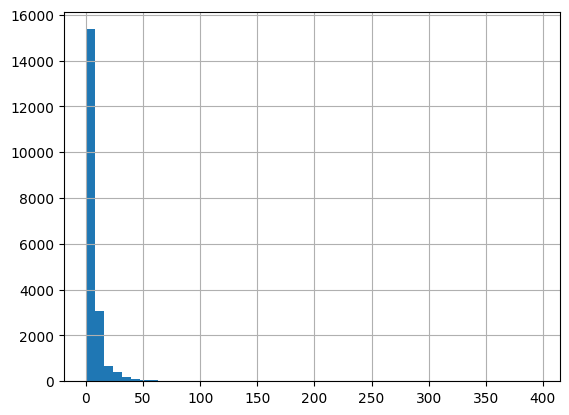

In [ ]:
df['selling_price'].hist(bins=50)

Lets check the percntage of outliers. We are manually taking a call that price over a 100 (K) is an outlier by looking at the above plot

In [ ]:
(df.loc[df.selling_price > 100].shape[0] / df.shape[0]) * 100

0.055055055055055056

Lets saturate selling price at **100**.

In [ ]:
df.loc[df.selling_price > 100, 'selling_price'] = 100

> **INTERACTION**
> -  Can you think of an automated way of deciding this threshold 100 ? Seems like we made this decision arbitarily
> - **Hint:** use quantiles

### Outliers and Missing Values

#### Q: Which plot(s) is/are suitable for outlier visualisation ?

Similarly lets plot a histogram for **mileage**

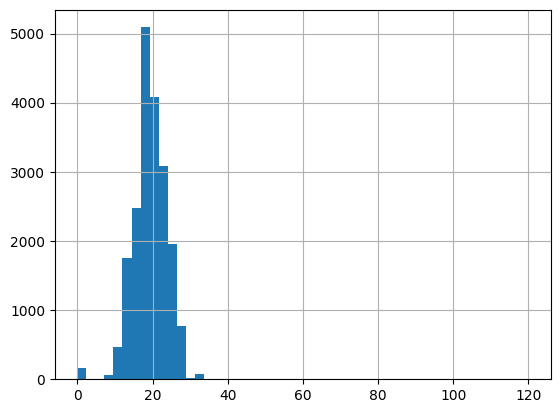

In [ ]:
df["mileage"].hist(bins=50);

Another useful plot is called the 'density' plot. Which is also similar to histogram, but with a more *approximate* shape. It tries to fit a suitable distribution over the histogram and hence includes points that might not even be present in data at hand.

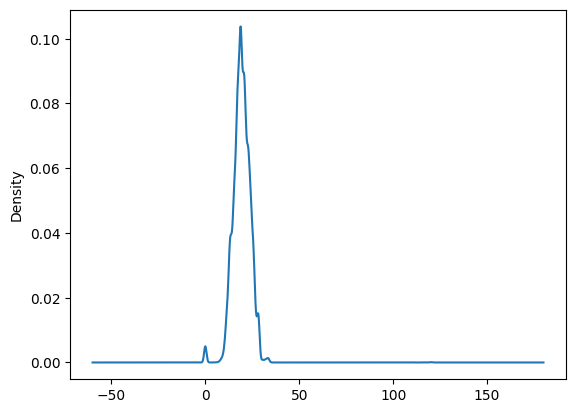

In [ ]:
df["mileage"].plot.density();

We observe a skewed plot with right tail to long. An interesting point here would be mileage > 40, because after that it looks like the values mught just be outliers.

Above we saw that there was an unusual peak at **0**. Lets investigate further. Looking at points where mileage is less than 5

In [ ]:
df[df["mileage"]<=5].mileage.describe()

count    161.000000
mean       0.024845
std        0.315244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: mileage, dtype: float64

Looks like we just have a number of points with mileage 0. That does not make much sense as it cannot be a real value for car mileage. Investigating mileage=0 cases

In [ ]:
df.loc[df.mileage == 0].shape[0] / df.shape[0] # 0.8 %

0.008008008008008008

In [ ]:
df[df["mileage"] == 0.0].shape

(160, 11)

Thats a very small number of points. We can safely impute, or drop these points later during pre-processing

#### Are the top values errorneous?

Above we had also noticed that there was a significant point at mileage=40. After this there were only very few points and looked like outliers. Lets check them

In [ ]:
df[df["mileage"] > 40].mileage.describe()

count      4.0
mean     117.5
std        5.0
min      110.0
25%      117.5
50%      120.0
75%      120.0
max      120.0
Name: mileage, dtype: float64

In [ ]:
df[df["mileage"] > 40]

,full_name,selling_price,year,seller_type,km_driven,fuel_type,transmission_type,mileage,engine,max_power,seats
11966,Mahindra e2oPlus P6,4.00,2018.0,Dealer,26000,Electric,Automatic,110.0,1476.327401,25.4,4.0
15684,Mahindra e2o T2,3.60,2015.0,Dealer,42862,Electric,Automatic,120.0,0.000000,25.5,5.0
17782,Mahindra e2o T2,4.50,2015.0,Dealer,40000,Electric,Automatic,120.0,0.000000,25.5,5.0
18401,Mahindra e2o Premium,3.25,2013.0,Individual,50000,Electric,Automatic,120.0,0.000000,25.5,5.0


In [ ]:
df[df["mileage"] > 40].fuel_type.value_counts()

Electric    4
Name: fuel_type, dtype: int64

- So all vehicles with mileage > 40 are electric vehicles which makes sense.
- So they are not incorrect (error) values.
- Let us not remove these points for now

### Correlations

Now lets look at the correlations of numerical features with each other

<ipython-input-18-9704d7d1b100>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


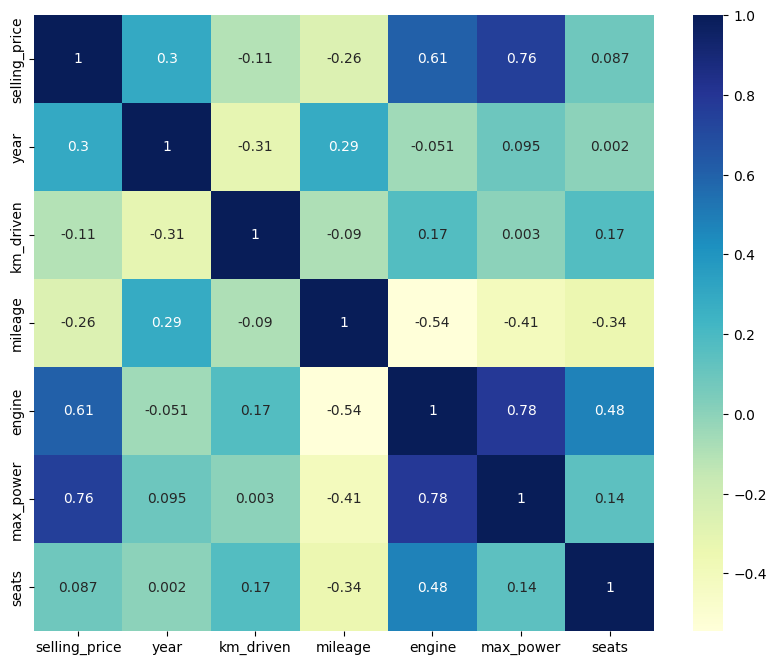

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

We see the following correlations:
- Engine and max-power
- Max power and selling price
Now based on our **domain knowledge** (about cars) we can digest these correlations. In this case, these correlations seem to make a lot of sense


Another visualisation we can check, is the scatter plot of each feature with the target. This can be easily done using pairplot from seaborn library

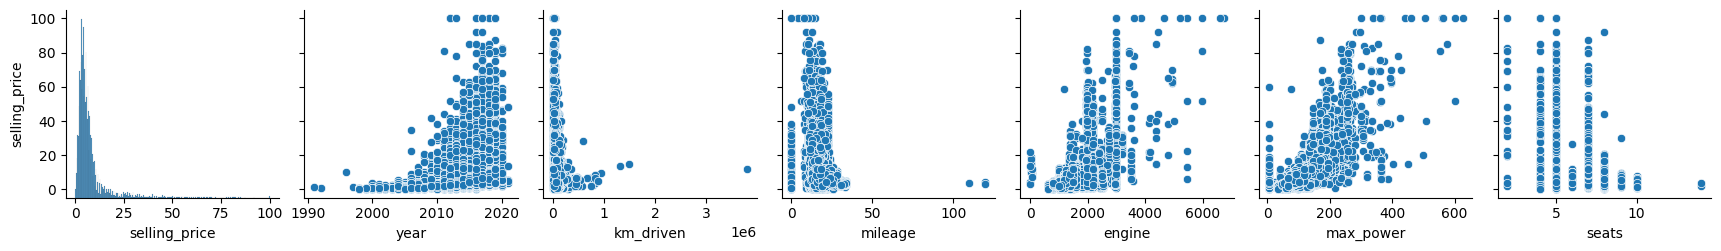

In [ ]:
sns.pairplot(df, y_vars=["selling_price"]);

In [ ]:
df['seats'].value_counts(normalize=True)

5.0     0.834885
7.0     0.118619
8.0     0.022022
4.0     0.011261
6.0     0.007157
9.0     0.003604
10.0    0.001301
2.0     0.001051
14.0    0.000100
Name: seats, dtype: float64

### Categorical Variables

#### How can we extract Make and Model from "full_name"

We have noticed that the name contains the informaiton of the brand and the model. Lets extract those and create new features from them. After that we can drop the original column

In [ ]:
df["make"] = df.full_name.apply(lambda x : x.split()[0])
df["model"] = df.full_name.apply(lambda x : " ".join(x.split()[1:]))
df = df.drop("full_name", axis=1)
df.head(2)

,selling_price,year,seller_type,km_driven,fuel_type,transmission_type,mileage,engine,max_power,seats,make,model
0,1.2,2012.0,Individual,120000,Petrol,Manual,19.7,796.0,46.3,5.0,Maruti,Alto Std
1,5.5,2016.0,Individual,20000,Petrol,Manual,18.9,1197.0,82.0,5.0,Hyundai,Grand i10 Asta


Now let us look at some categorical variables one by one

In [ ]:
display(df.describe(include="object"))

,seller_type,fuel_type,transmission_type,make,model
count,19980,19980,19980,19980,19980
unique,3,5,2,42,3321
top,Dealer,Diesel,Manual,Maruti,Swift Dzire VDI
freq,11973,9817,16029,5650,210


In [ ]:
df["fuel_type"].value_counts()

Diesel      9817
Petrol      9767
CNG          316
LPG           66
Electric      14
Name: fuel_type, dtype: int64

In [ ]:
df["transmission_type"].value_counts()

Manual       16029
Automatic     3951
Name: transmission_type, dtype: int64

In [ ]:
df["seller_type"].value_counts()

Dealer              11973
Individual           7817
Trustmark Dealer      190
Name: seller_type, dtype: int64

#### Does selling price vary in some of these groups

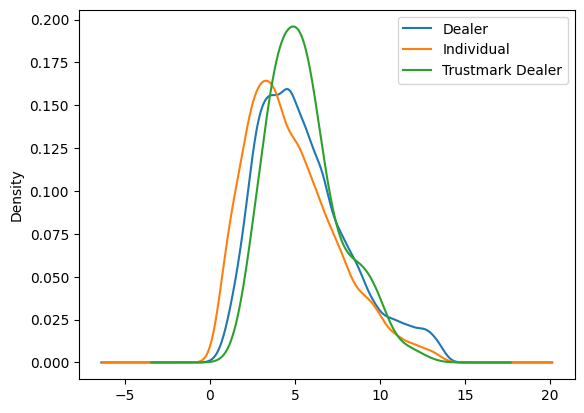

In [ ]:
df.loc[df.selling_price<=df.selling_price.quantile(0.9)].groupby('seller_type')['selling_price'].plot.density();
plt.legend();

Looks like for different seller type, the selling price distrubution is not very different. Hence one intuition that can be developed from this plot is that the **seller_type** variable will not turn out to be very important for the ML model. (We will check this later)

#### Lets check for all groups?

Another way to visualise the same is to use a plot known as **box-plot**


Note: Although, `seats` is numeric, but we will consider it as an ordinal variable and perform similar analysis as we do for other categorical variables.

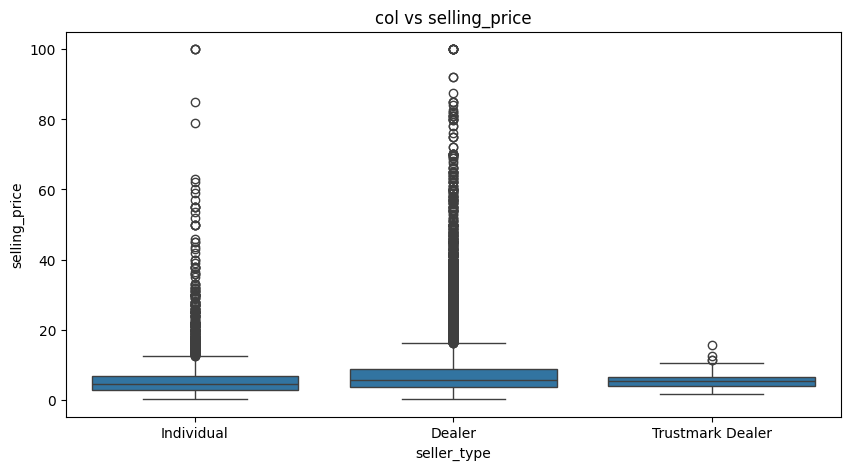

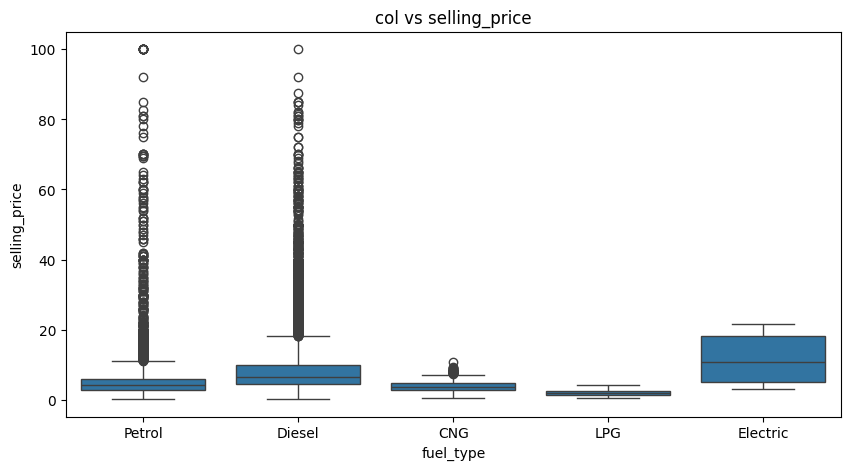

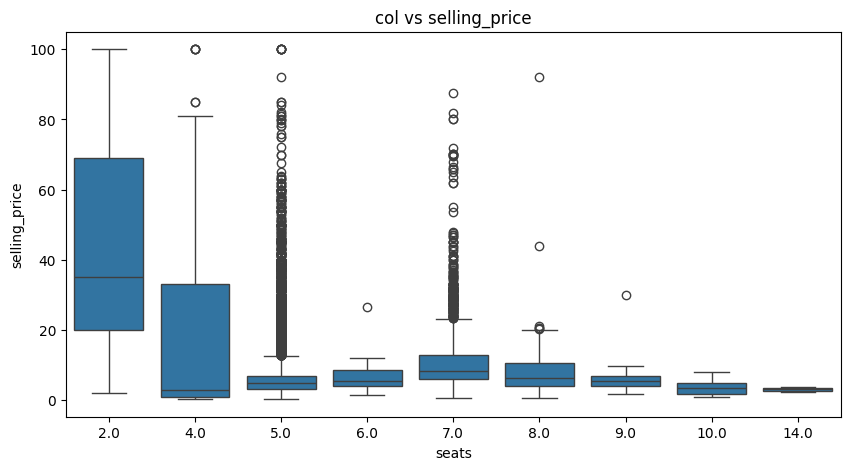

In [ ]:
for col in ['seller_type', 'fuel_type', 'seats']:
    plt.figure(figsize=(10,5))
    sns.boxplot(y='selling_price',x=col, data=df)
    plt.title('col vs selling_price')
    plt.show()

#### How can we transform the scale of selling-price for better visualisation?

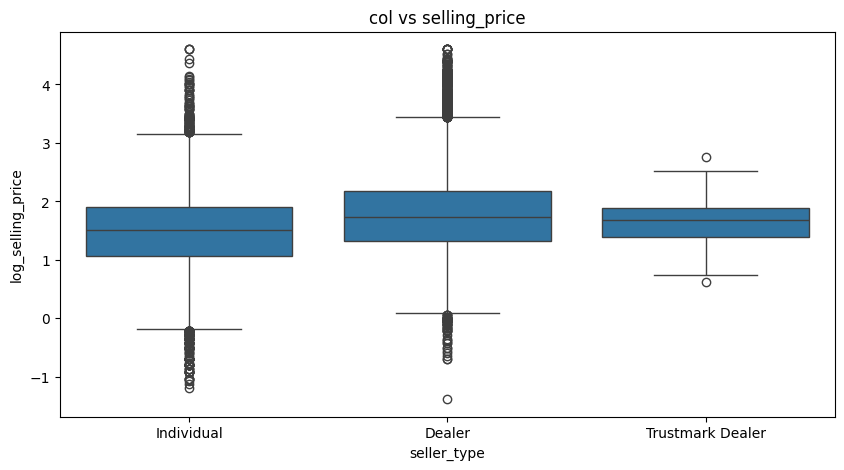

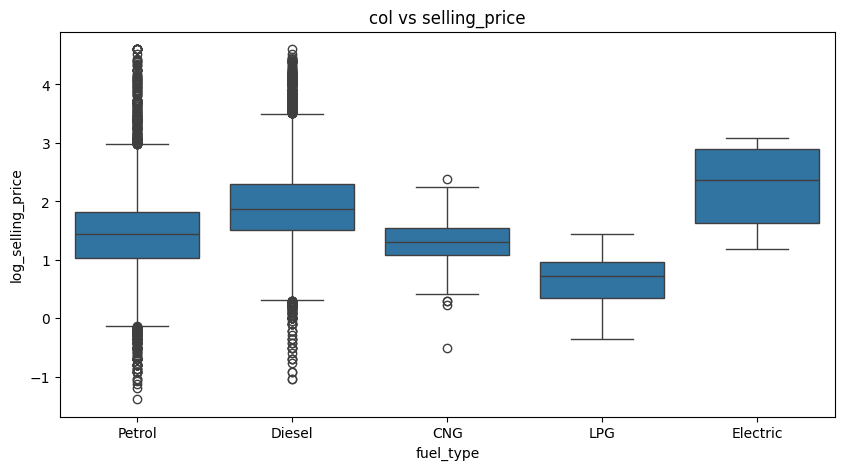

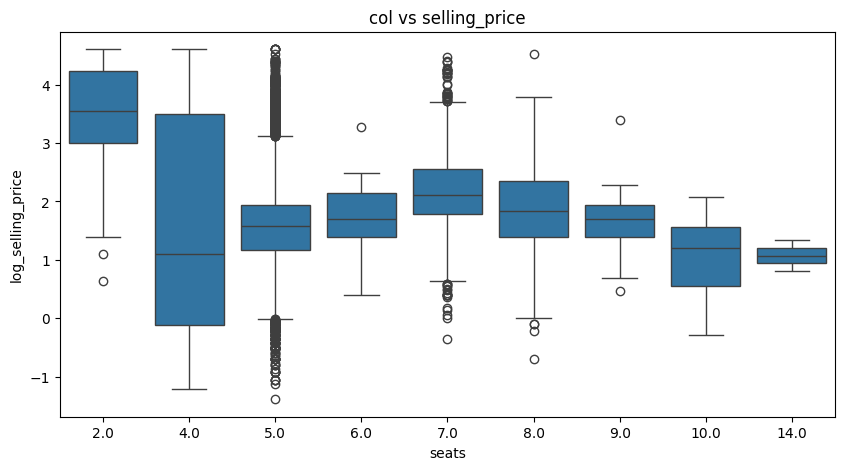

In [ ]:
df["log_selling_price"] = np.log(df["selling_price"].values)

for col in ['seller_type', 'fuel_type', 'seats']:
    plt.figure(figsize=(10,5))
    sns.boxplot(y='log_selling_price',x=col, data=df)
    plt.title('col vs selling_price')
    plt.show()

 - `selling_price` of "coupe" is quite variational - important to be kept for predictive modelling

#### How many categories of "make" in the data?  

In [ ]:
len(df["make"].unique())

42

There are 42 car brands in the data - too many levels, think of possible ways to encode them as numbers

#### What are item counts for different "make"?

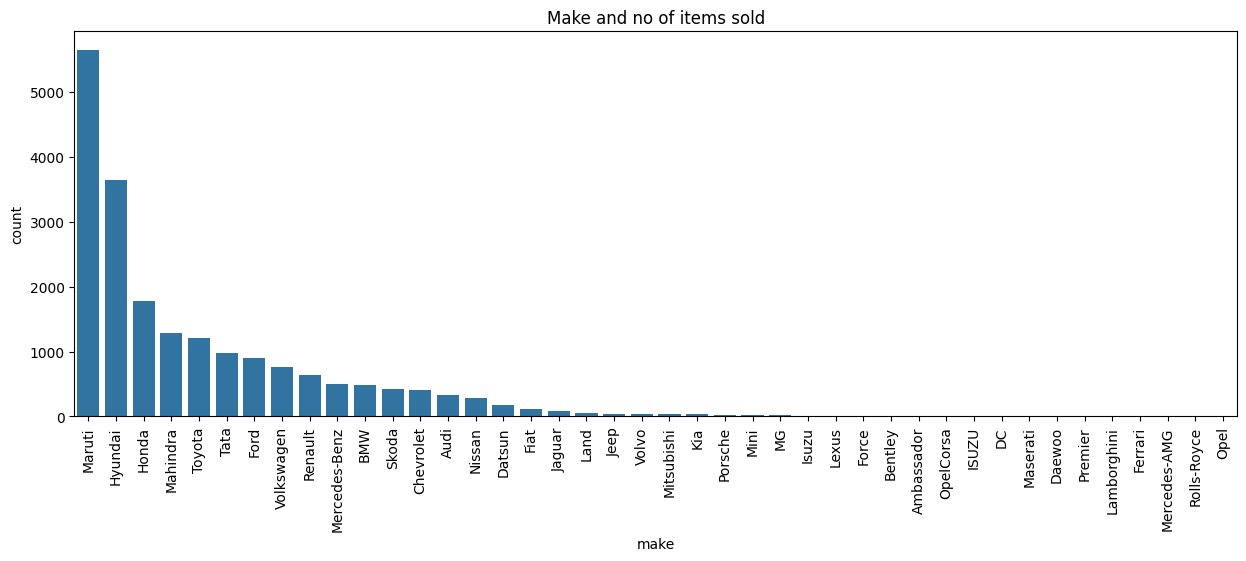

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x='make', data=df, order = df['make'].value_counts().index)
plt.xticks(rotation=90);
plt.title("Make and no of items sold")
plt.show()

#### How is "make" related to the selling price?

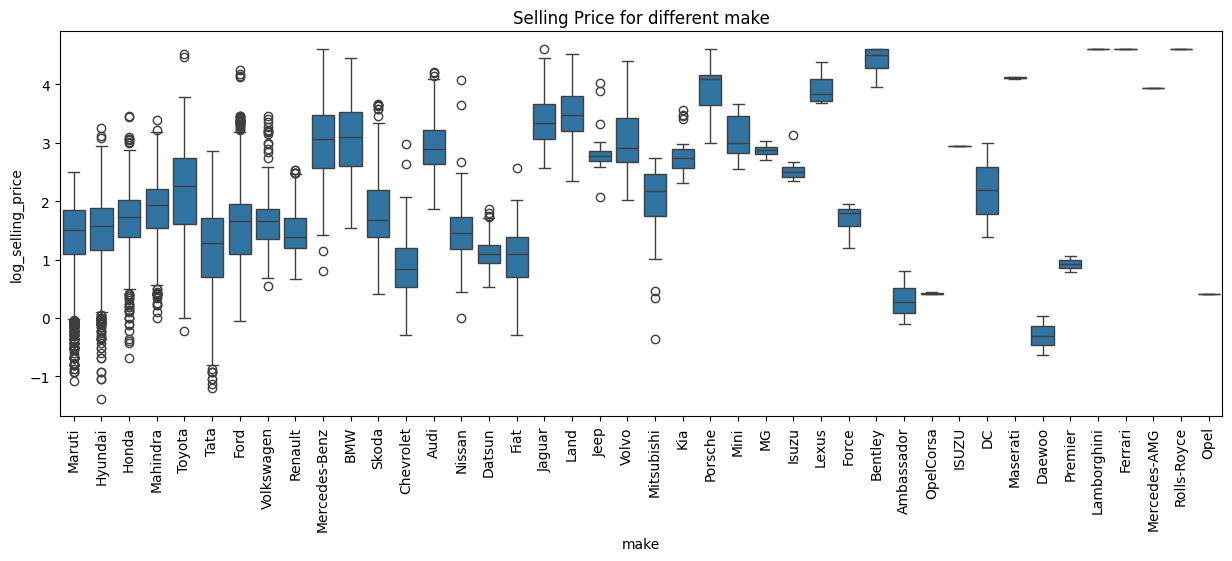

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(y='log_selling_price',x='make', data=df, order = df['make'].value_counts().index)
plt.xticks(rotation=90);
plt.title("Selling Price for different make")
plt.show()

Lets drop this column for now

In [ ]:
df.drop("log_selling_price", axis=1, inplace=True)


> **How should we treat number of seats? Continuous OR Categorical ?**



> Number of seats is a variable with a finite discrete set of values. However it is orderd. If we make it categorical, it would be fed into the model as unordered.

> But we need to think do we want that order?

> Example: 2 seater cars are most likely more expensive than other cars. So in this sense 2 > 5. We actually would benefit from discarding the order.


---
# Feature Engineering


In [ ]:
df.head()

,selling_price,year,seller_type,km_driven,fuel_type,transmission_type,mileage,engine,max_power,seats,make,model
0,1.20,2012.0,Individual,120000,Petrol,Manual,19.70,796.0,46.30,5.0,Maruti,Alto Std
1,5.50,2016.0,Individual,20000,Petrol,Manual,18.90,1197.0,82.00,5.0,Hyundai,Grand i10 Asta
2,2.15,2010.0,Individual,60000,Petrol,Manual,17.00,1197.0,80.00,5.0,Hyundai,i20 Asta
3,2.26,2012.0,Individual,37000,Petrol,Manual,20.92,998.0,67.10,5.0,Maruti,Alto K10 2010-2014 VXI
4,5.70,2015.0,Dealer,30000,Diesel,Manual,22.77,1498.0,98.59,5.0,Ford,Ecosport 2015-2021 1.5 TDCi Titanium BSIV


### 1. Year

Sometimes it is good practice to convert the features into the way we actually understand. This will not necessarily help the model, but helps in us in understanding / interpreting predictions little better

- So lets convert year to more readable ***age***

In [ ]:
from datetime import datetime

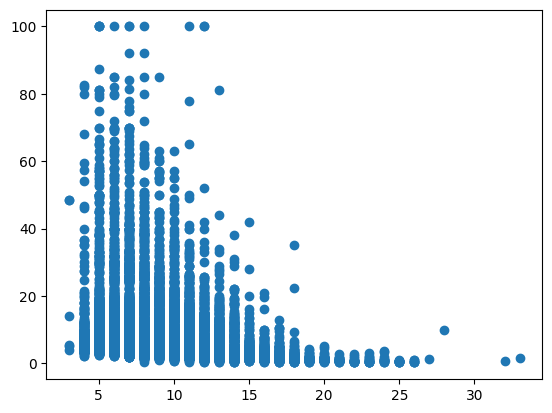

In [ ]:
current_year = datetime.now().year
age = current_year - df['year']
plt.scatter(age, df.selling_price)

**Higher selling price for newer cars !!**

### 2. Categorical Encoding

#### Q: How do we encode categorical variables for modelling?

#### 2.1 transmission_type (2 categories)

In [ ]:
# explains how two category variable can be encoded as a binary variable
transmission_dummy = pd.get_dummies(df["transmission_type"])
df = pd.concat([df, transmission_dummy], axis=1)
df = df.drop(["transmission_type", "Automatic"], axis=1)
df = df.rename(columns={"Manual": "transmission_type"})
df.sample(frac=1).head(2)

,selling_price,year,seller_type,km_driven,fuel_type,mileage,engine,max_power,seats,make,model,transmission_type
3744,2.95,2011.0,Dealer,84000,Diesel,23.50,1498.0,90.00,5.0,Ford,Fiesta Titanium 1.5 TDCi,1
19239,2.40,2013.0,Dealer,32000,Petrol,23.95,998.0,67.05,5.0,Maruti,Alto K10 VXI,1


#### 2.2 fuel_type (5 categores)

In [ ]:
fuel_type_dummy = pd.get_dummies(df["fuel_type"], prefix="seats")
fuel_type_dummy.sample(frac=1).head(2)

,seats_CNG,seats_Diesel,seats_Electric,seats_LPG,seats_Petrol
15119,0,0,0,0,1
13717,0,0,0,0,1


**NOTE:** We remove 1 of the dummy variables to avoid the dummy variable trap

In [ ]:
fuel_type_dummy = fuel_type_dummy[fuel_type_dummy.columns[1:]]
fuel_type_dummy.head(2)

,seats_Diesel,seats_Electric,seats_LPG,seats_Petrol
0,0,0,0,1
1,0,0,0,1


In [ ]:
pd.concat([df, fuel_type_dummy], axis=1).sample(frac=1).head(2)

,selling_price,year,seller_type,km_driven,fuel_type,mileage,engine,max_power,seats,make,model,transmission_type,seats_Diesel,seats_Electric,seats_LPG,seats_Petrol
17837,3.97,2012.0,Dealer,34239,Petrol,18.40,1198.0,86.80,5.0,Honda,Brio AT,0,0,0,0,1
4348,3.35,2014.0,Dealer,60137,Diesel,21.02,1248.0,88.76,5.0,Tata,Manza Club Class Quadrajet90 VX,1,1,0,0,0


#### 2.3 make (too many categoies)

In [ ]:
df.make.nunique()

42

> **INTERACTION**
> - How to handle so many categories?
> **Hint:** Here we have too many categories. We can merge categories as in 'seats' variable or we can try target encoding. Dummy encoding would make too many features with highly diluted information.

Or we can try another technique known as **Target Encoding**

In [ ]:
encoded_make = df.groupby('make')['selling_price'].transform('mean')

In [ ]:
show_df = df[['make']].copy()
show_df['encoded_make'] = encoded_make
show_df = show_df.drop_duplicates()
print(len(show_df))
show_df.head()

42


,make,encoded_make
0,Maruti,4.684721
1,Hyundai,5.374923
4,Ford,6.265275
9,Mahindra,7.303129
10,Tata,4.395415


### 3. Scaling

#### Q: Now, All these variables have different ranges. Does that work?

In [ ]:
df.describe()

,selling_price,year,km_driven,mileage,engine,max_power,seats,transmission_type
count,19980.000000,19980.000000,1.998000e+04,19980.000000,19980.000000,19980.000000,19980.000000,19980.000000
mean,7.353527,2014.525125,5.824488e+04,19.347219,1476.327401,97.854443,5.317868,0.802252
std,8.312958,3.249185,5.172509e+04,4.620053,520.449398,45.080670,0.835370,0.398311
min,0.250000,1991.000000,1.000000e+02,0.000000,0.000000,5.000000,2.000000,0.000000
25%,3.400000,2013.000000,3.116425e+04,16.800000,1197.000000,73.900000,5.000000,1.000000
50%,5.200000,2015.000000,5.200000e+04,19.160000,1248.000000,86.700000,5.000000,1.000000
75%,7.850000,2017.000000,7.400000e+04,22.320000,1582.000000,112.000000,5.000000,1.000000
max,100.000000,2021.000000,3.800000e+06,120.000000,6752.000000,626.000000,14.000000,1.000000


Lets scale this data. We will use MinMaxScaler here (in practice you can choose your scaling techniques depending on the problem, or just try all and see what works best)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaler.fit(df[['selling_price', 'km_driven', 'mileage']])
scaled_values = scaler.transform(df[['selling_price', 'km_driven', 'mileage']])  # returns numpy.ndarray not df.
scaled_df = pd.DataFrame(scaled_values, columns=['selling_price', 'km_driven', 'mileage'])
scaled_df.head()

,selling_price,km_driven,mileage
0,0.009524,0.031553,0.164167
1,0.052632,0.005237,0.157500
2,0.019048,0.015764,0.141667
3,0.020150,0.009711,0.174333
4,0.054637,0.007869,0.189750


In [ ]:
scaled_df.describe()

,selling_price,km_driven,mileage
count,19980.000000,19980.000000,19980.000000
mean,0.071213,0.015302,0.161227
std,0.083338,0.013612,0.038500
min,0.000000,0.000000,0.000000
25%,0.031579,0.008175,0.140000
50%,0.049624,0.013658,0.159667
75%,0.076190,0.019448,0.186000
max,1.000000,1.000000,1.000000


---
## Stichting it all together



In [ ]:
def merge_seats(x):
    if 2 <= x <= 4:
        return '2-4'
    elif x > 5:
        return '>5'
    else:
        return '5'

def preprocess(df):
    df = df.loc[df.mileage != 0].copy()
    outlier_theshold = df.selling_price.quantile(0.95)
    df.loc[df.selling_price > outlier_theshold, 'selling_price'] = outlier_theshold
    df['age'] = pd.to_datetime('now', utc=True).date().year - df['year']
    df['full_name'] = df['full_name'].str.upper()
    df['seats'] = df['seats'].apply(merge_seats)
    df.drop(columns=['year'])
    return df

def feature_engineering(df):
    df['make'] = df.full_name.apply(lambda x : x.split()[0])
    df['model'] = df.full_name.apply(lambda x : " ".join(x.split()[1:]))
    one_hot_encode_cols = ['seller_type', 'fuel_type', 'transmission_type', 'seats']
    for column in one_hot_encode_cols:
        df = pd.concat([df, pd.get_dummies(df[column]).iloc[: , 1:]], axis=1)
    df.drop(columns=one_hot_encode_cols + ['full_name'], inplace=True)
    df['make'] = df.groupby('make')['selling_price'].transform('median')
    df['model'] = df.groupby('model')['selling_price'].transform('median')
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df

In [ ]:
df = pd.read_csv("cars24-car-price.csv")
df = preprocess(df)
df = feature_engineering(df)
df.head()

,selling_price,year,km_driven,mileage,engine,max_power,age,make,model,Individual,Trustmark Dealer,Diesel,Electric,LPG,Petrol,Manual,5,>5
0,0.043684,0.689655,0.031553,0.135345,0.117891,0.066506,0.310345,0.184371,0.042522,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.252397,0.827586,0.005237,0.128448,0.177281,0.123994,0.172414,0.207231,0.225975,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,0.089795,0.620690,0.015764,0.112069,0.177281,0.120773,0.379310,0.207231,0.120277,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,0.095134,0.689655,0.009711,0.145862,0.147808,0.100000,0.310345,0.184371,0.093549,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.262104,0.793103,0.007869,0.161810,0.221860,0.150709,0.206897,0.224624,0.300085,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
df.shape

(19820, 18)

#### Correlations with all numeric features

And before we wrap up, lets just see correlations of all variables since now we have all usable information in numerical form

<Axes: >

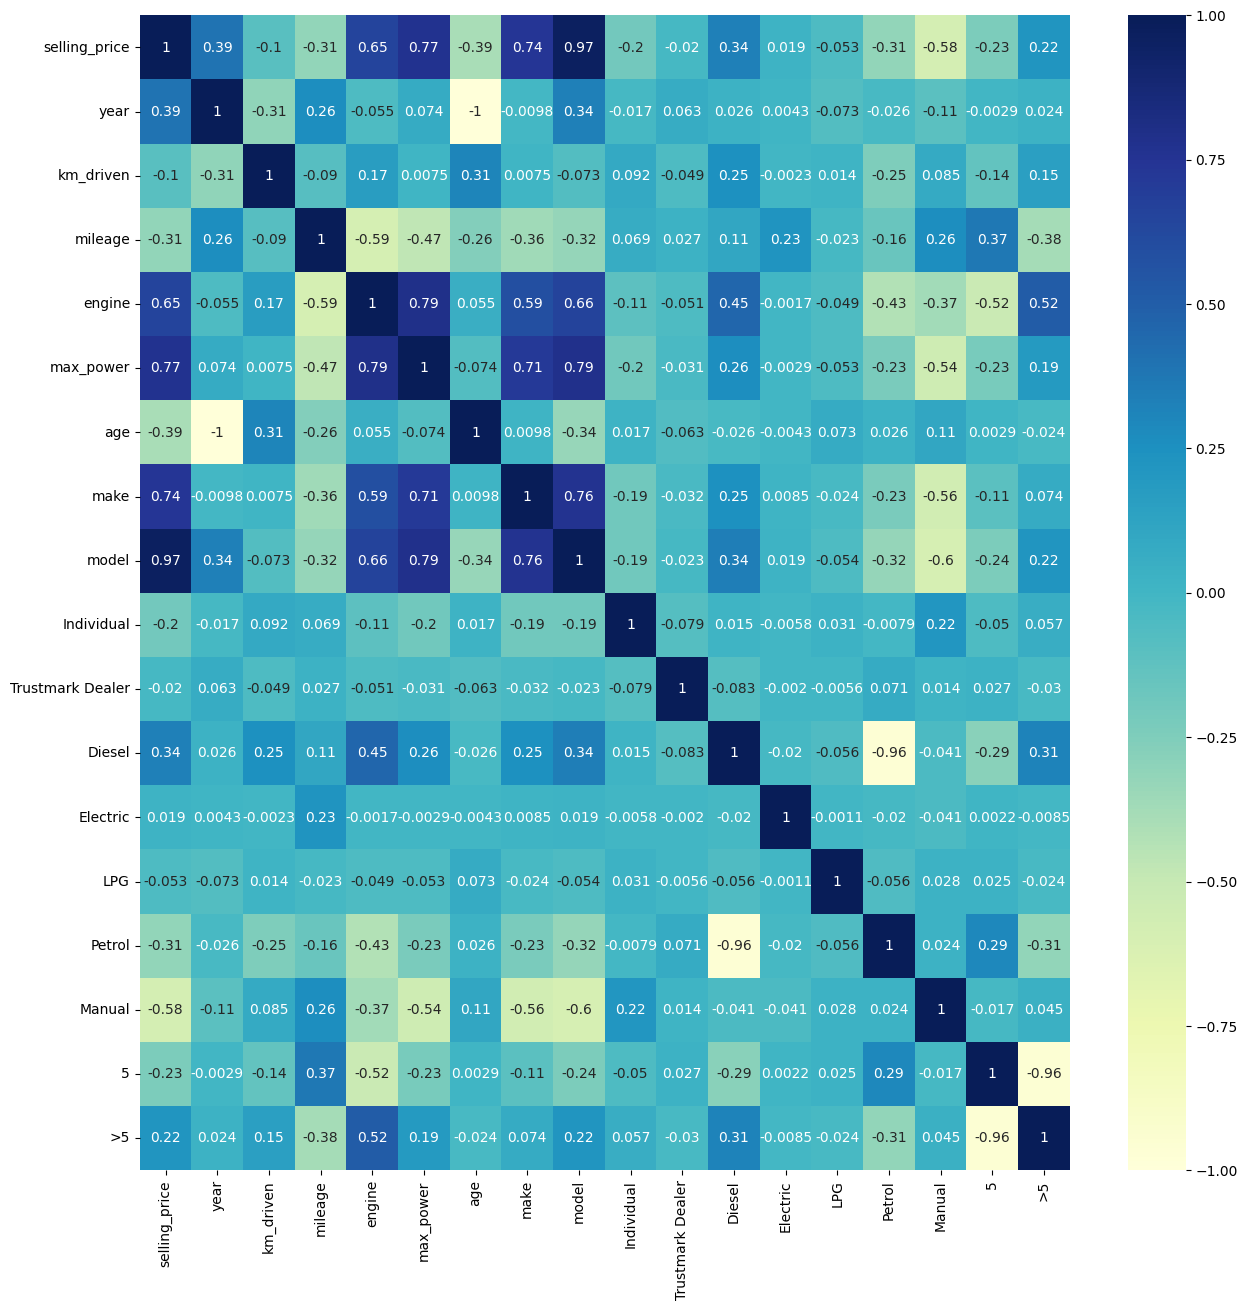

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

- `max_power`, `engine` and `transmission_type` are hightest correlated with `selling_price` in same order.
- New encoded features are weak predictor, but they together would might make strong predictors.

---